# Language Classification
This notebook contains the code for a CNN that classifies spoken language.

Used as reference:

https://github.com/pietz/language-recognition/blob/master/Language%20Classifier.ipynb

https://github.com/sergeyvilov/MCV-spoken-language-recognition/blob/master/audio_models.py

https://towardsdatascience.com/spoken-language-recognition-on-mozilla-common-voice-part-ii-models-b32780ea1ee4

https://towardsdatascience.com/spoken-language-recognition-on-mozilla-common-voice-part-i-3f5400bbbcd8

## Data Processing

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from keras.preprocessing import image
from tqdm import tqdm

In [2]:
# langs = ["ar", "en", "zh-CN"]
# lang_nums = {
#     "ar": 0,
#     # "de": 1,
#     "en": 1,
#     # "es": 3,
#     # "fr": 4,
#     # "hi": 5,
#     # "it": 6,
#     # "ja": 7,
#     # "ru": 8,
#     "zh-CN": 2
# }

langs = ["ar", "de", "en", "es", "fr", "hi", "it", "ja", "ru", "zh-CN"]
# langs = ["ar", "de", "en"]
lang_nums = {
    "ar": 0,
    "de": 1,
    "en": 2,
    "es": 3,
    "fr": 4,
    "hi": 5,
    "it": 6,
    "ja": 7,
    "ru": 8,
    "zh-CN": 9
}

num_to_lang = {v: k for k, v in lang_nums.items()}

In [3]:
def load_images_from_path(path, label, num_images=1000, shuffle=True):
    images = []
    labels = []

    count = 0
    files = os.listdir(path)
    if shuffle:
        files = np.random.choice(files, num_images, replace=False)
    else:
        files = files[:num_images]
    for file in tqdm(files):
        # print(f"{count} - {file}")
        if count >= num_images:
            break
        try:
            img = image.img_to_array(image.load_img(os.path.join(path, file) , target_size=(192, 192, 3)).convert('L'))
            img = img.reshape((192, 192, 1))
            # from 255 to 0-1
            img = img / 255
            images.append(img)
            labels.append((label))
            count += 1
        except Exception as e:
            print(f"Error loading image: {file}")
            print(e)
        
    return images, labels

def show_images(images, label):
    fig, axes = plt.subplots(1, 8, figsize=(20, 20), subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        # ax.imshow(images[i] / 255)
        ax.set_title(num_to_lang[labels[i]])  # Set the title for the subplot

ar


100%|██████████| 2000/2000 [00:00<00:00, 3589.61it/s]


de


100%|██████████| 2000/2000 [00:00<00:00, 3660.60it/s]


en


100%|██████████| 2000/2000 [00:00<00:00, 3495.97it/s]


es


100%|██████████| 2000/2000 [00:00<00:00, 3620.57it/s]


fr


100%|██████████| 2000/2000 [00:00<00:00, 3615.37it/s]


hi


100%|██████████| 2000/2000 [00:00<00:00, 3695.52it/s]


it


100%|██████████| 2000/2000 [00:00<00:00, 3408.85it/s]


ja


100%|██████████| 2000/2000 [00:00<00:00, 3526.50it/s]


ru


100%|██████████| 2000/2000 [00:00<00:00, 3404.56it/s]


zh-CN


100%|██████████| 2000/2000 [00:00<00:00, 3381.42it/s]


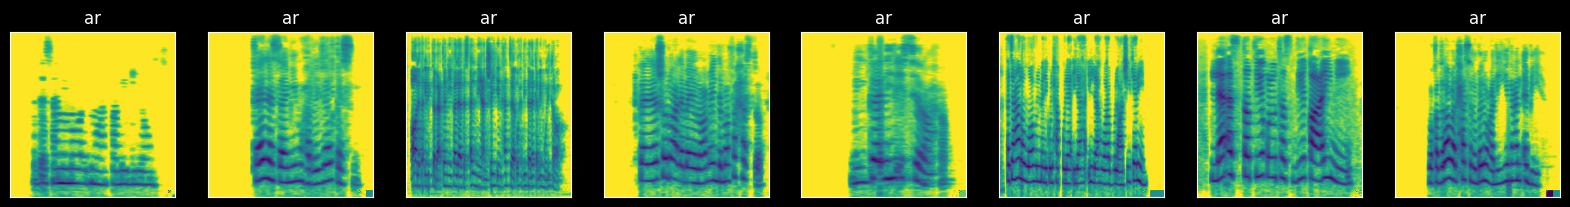

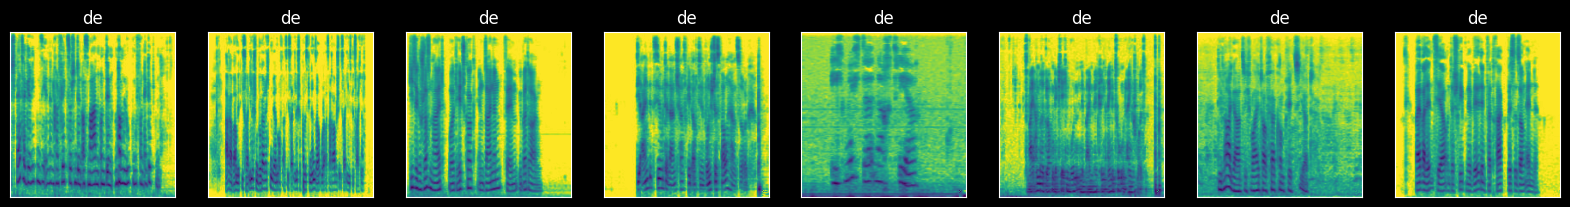

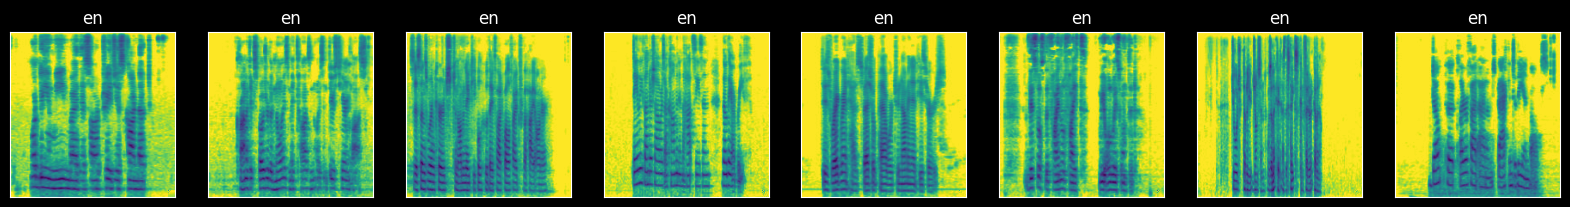

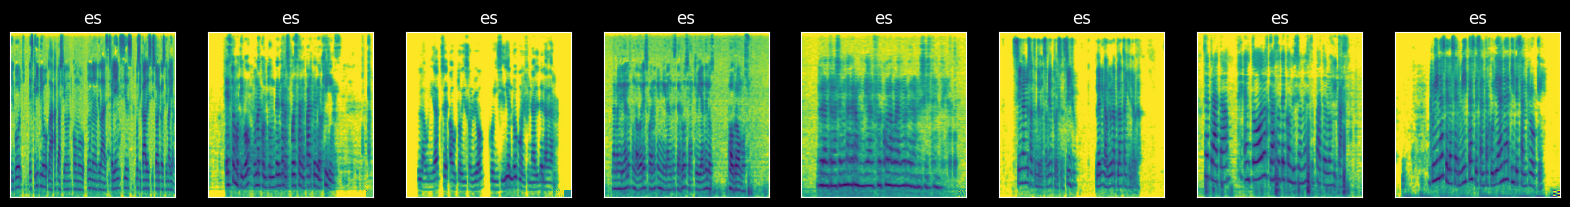

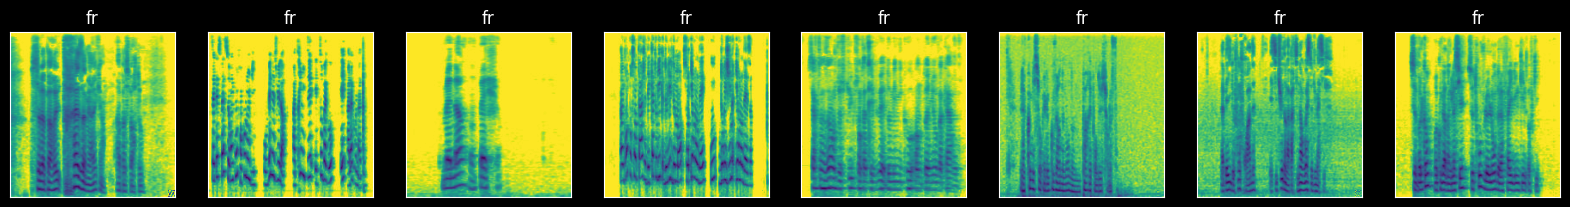

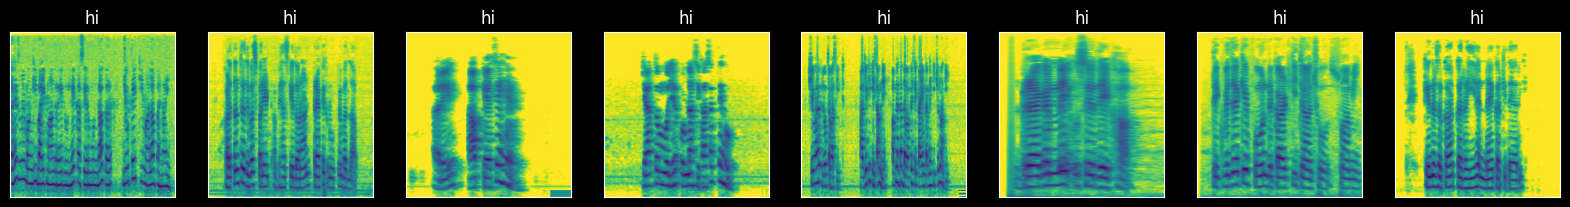

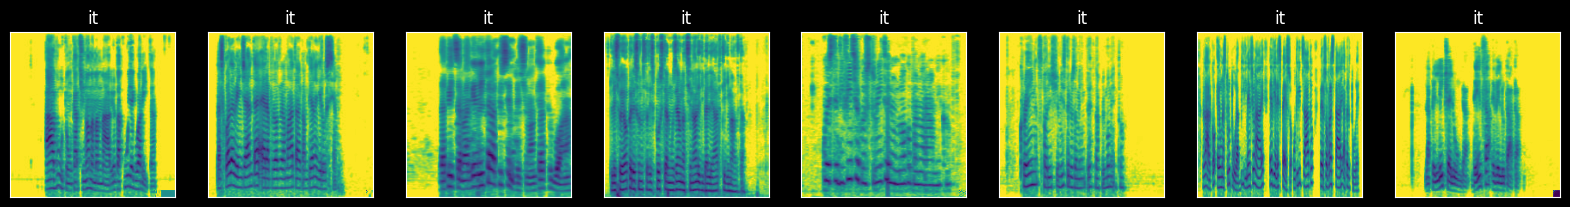

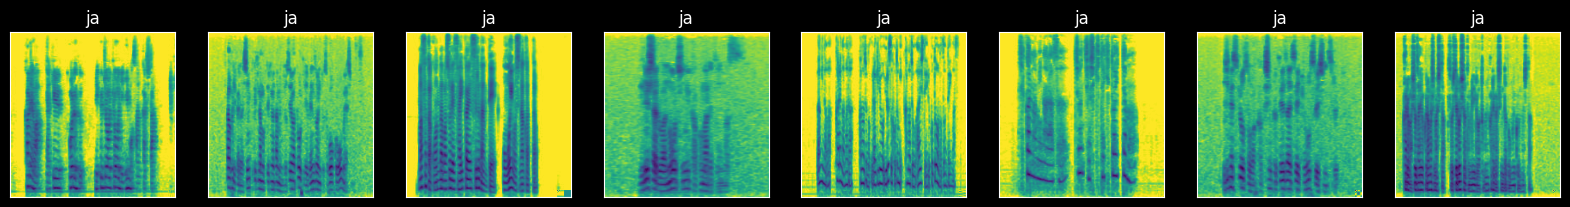

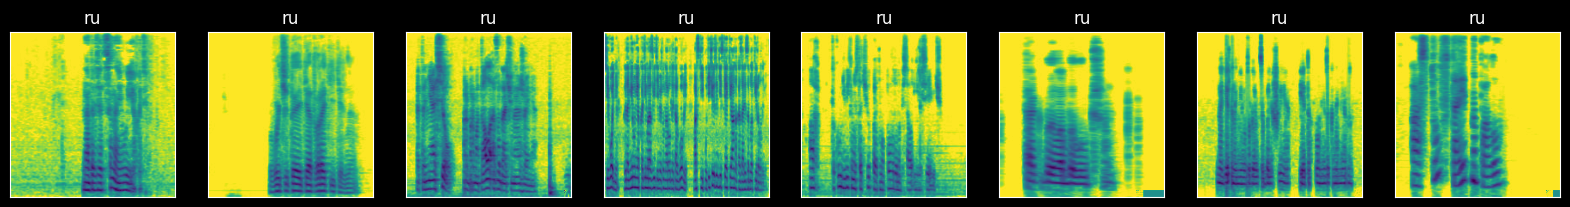

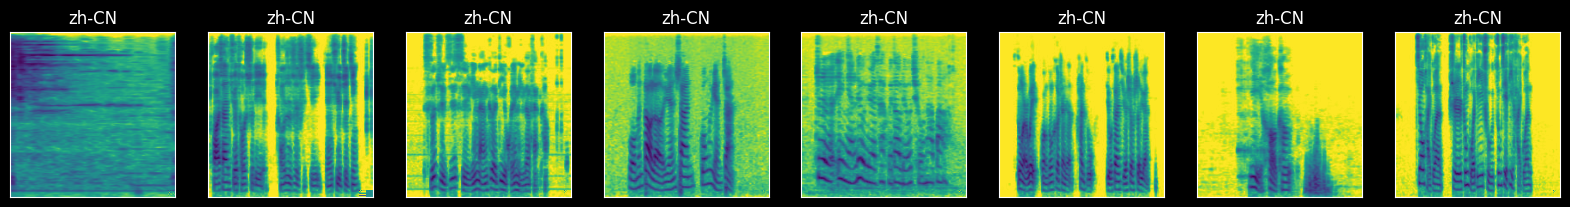

In [4]:
x = []
y = []
NUM_IMGS = 2000

for lang in langs:
    print(lang)
    path = f"data/spectrogram/{lang}_train/"
    images, labels = load_images_from_path(path, lang_nums[lang], num_images=NUM_IMGS, shuffle=False)
    x += images
    y += labels
    show_images(images, labels)

In [5]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.3, random_state=0)

x_train_arr = np.array(x_train)
x_test_arr = np.array(x_test)

y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

In [7]:
# truncate dataset for faster training:
x_train_arr = x_train_arr[:NUM_IMGS]
x_test_arr = x_test_arr[:NUM_IMGS]

y_train_encoded = y_train_encoded[:NUM_IMGS]
y_test_encoded = y_test_encoded[:NUM_IMGS]

print(x_train_arr.shape)
print(y_train_encoded.shape)

(2000, 192, 192, 1)
(2000, 10)


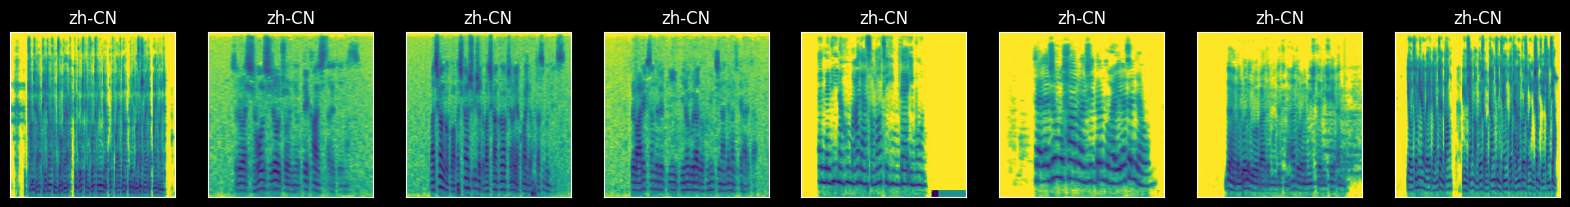

In [8]:
show_images(x_train_arr, y_train)

## Model

In [9]:
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

In [10]:
# model = Sequential()
# model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(192, 192, 1)))
# model.add(MaxPooling2D(2, 2))
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(MaxPooling2D(2, 2))
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(MaxPooling2D(2, 2))
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(MaxPooling2D(2, 2))
# model.add(Flatten())
# model.add(Dense(1024, activation='relu'))
# model.add(Dense(len(langs), activation='softmax'))
# model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()

In [11]:
# architecture from
# https://github.com/pietz/language-recognition/blob/master/Language%20Classifier.ipynb

in_dim = (192, 192, 1)  # 192x192 grayscale images (1 color channel)
out_dim = len(langs) # number of langs

i = Input(shape=in_dim)
m = Conv2D(16, (3, 3), activation='elu', padding='same')(i)
m = MaxPooling2D()(m)
m = Conv2D(32, (3, 3), activation='elu', padding='same')(m)
m = MaxPooling2D()(m)
m = Conv2D(64, (3, 3), activation='elu', padding='same')(m)
m = MaxPooling2D()(m)
m = Conv2D(128, (3, 3), activation='elu', padding='same')(m)
m = MaxPooling2D()(m)
m = Conv2D(256, (3, 3), activation='elu', padding='same')(m)
m = MaxPooling2D()(m)
m = Flatten()(m)
m = Dense(512, activation='elu')(m)
m = Dropout(0.5)(m)
o = Dense(out_dim, activation='softmax')(m)

model = Model(inputs=i, outputs=o)

# Change learning rate
opta = tf.keras.optimizers.Nadam(learning_rate=1e-3)
optb = tf.keras.optimizers.Nadam(learning_rate=1e-4)

model.compile(loss='categorical_crossentropy', optimizer=opta, metrics=['accuracy'])
# model.compile(loss='categorical_crossentropy', optimizer=optb, metrics=['accuracy'])
# model.fit(x_tr, y_tr, epochs=3, verbose=1, validation_data=(x_va, y_va))

# model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 192, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 192, 192, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 96, 96, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 48, 48, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        18496 

In [12]:
print(x_train_arr.shape)
print(y_train_encoded.shape)
print(x_test_arr.shape)
print(y_test_encoded.shape)
# print number per class
print(np.unique(y_train, return_counts=True))

(2000, 192, 192, 1)
(2000, 10)
(2000, 192, 192, 1)
(2000, 10)
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([1400, 1400, 1400, 1400, 1400, 1400, 1400, 1400, 1400, 1400]))


## Train

In [13]:
hist = model.fit(x_train_arr, y_train_encoded, validation_data=(x_test_arr, y_test_encoded), batch_size=8, epochs=8, verbose=1)

Epoch 1/8
250/250 [==============================] - 19s 72ms/step - loss: 2.1945 - accuracy: 0.2205 - val_loss: 1.9254 - val_accuracy: 0.2915
Epoch 2/8
250/250 [==============================] - 18s 73ms/step - loss: 1.8183 - accuracy: 0.3595 - val_loss: 1.9194 - val_accuracy: 0.3355
Epoch 3/8
250/250 [==============================] - 20s 78ms/step - loss: 1.5435 - accuracy: 0.4565 - val_loss: 1.8567 - val_accuracy: 0.3770
Epoch 4/8
250/250 [==============================] - 19s 75ms/step - loss: 1.1579 - accuracy: 0.6095 - val_loss: 2.0402 - val_accuracy: 0.3580
Epoch 5/8
250/250 [==============================] - 19s 76ms/step - loss: 0.6981 - accuracy: 0.7505 - val_loss: 2.5615 - val_accuracy: 0.3510
Epoch 6/8
250/250 [==============================] - 21s 84ms/step - loss: 0.3100 - accuracy: 0.8930 - val_loss: 2.9432 - val_accuracy: 0.3795
Epoch 7/8
250/250 [==============================] - 19s 77ms/step - loss: 0.3230 - accuracy: 0.8940 - val_loss: 3.8326 - val_accuracy: 0.3505

[]

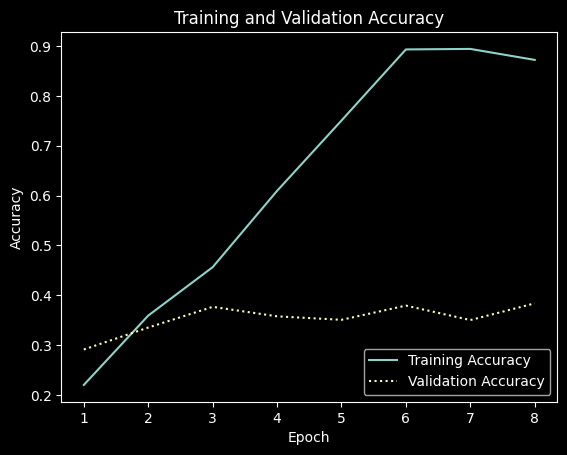

In [14]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

In [15]:
model.save('lang_classifier.keras')

In [16]:
# statically type model
model.test_on_batch(x_test_arr, y_test_encoded)
# .557 accuracy
# .729 accuracy (3 langs)
# .384 accuracy (10 langs)

[3.924574136734009, 0.3840000033378601]

In [17]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

In [18]:
sns.set()
label_encoder = LabelEncoder()
y_predicted = model.predict(x_test_arr)

63/63 [==============================] - 3s 49ms/step


Text(110.44999999999997, 0.5, 'Actual label')

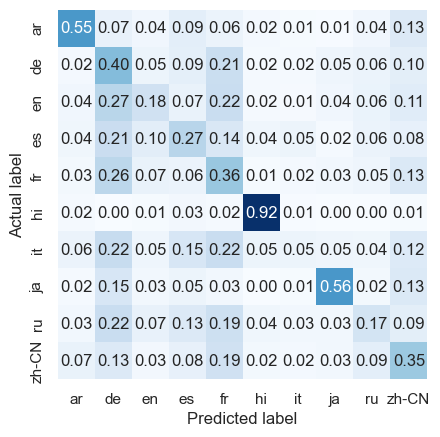

In [19]:

y_test_encoded = label_encoder.fit_transform(y_test_encoded.argmax(axis=1))  # Replace y_test with your actual labels
y_predicted_encoded = label_encoder.transform(y_predicted.argmax(axis=1))

mat = confusion_matrix(y_test_encoded, y_predicted_encoded, normalize='true')


sns.heatmap(mat, square=True, annot=True, fmt='.2f', cbar=False, cmap='Blues', xticklabels=langs, yticklabels=langs)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')